In [1]:
%load_ext autoreload
%autoreload 2
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri
import rpy2
from pprint import pprint
import re
import numpy as np
import pickle
from collections import OrderedDict
from itertools import repeat, count, product
from skbio.alignment import StripedSmithWaterman, local_pairwise_align_ssw
import sys
sys.path.append("..")
from analysis_tools import KmerAligner
%run ../lib.ipynb

In [2]:
SRATE = 5000

In [3]:
robjects.r['load']("../../../../david_eccles_bc_ideas/mtDNA_mappable_called_with_rawSignal.Rdata")

<StrVector - Python:0x7ffe4478fd88 / R:0x3b18d28>
['nanopore.bundled']

In [4]:
data = numpy2ri.ri2py(robjects.r['nanopore.bundled'])

In [5]:
files = !find ../../david_eccles_bc_ideas/processed/ | grep fast5

### Get data from RData

0 = reference
1 = called
3 = channel
8 = metrichor results (events)
9 = "mux"
10 = signal range 
11 = signal

In [6]:
ref = data[0][0]
channel_ids = [int(x) for x in data[3]]
file_ids = [int(x) for x in data[5]]
types = list(data[2].names) #template/2D/...

In [11]:
## channel coords from rdata
coords = []
all_raw = {}
channel_max = dict(zip(channel_ids, repeat(0)))
for i in range(0, len(data[10]), 2):
    se = (round(data[10][i]), round(data[10][i+1]))
    coords.append(se)
    channel_max[channel_ids[int(i/2)]] = max(channel_max[channel_ids[int(i/2)]], se[1])
    
print (channel_max)

for chid, chmax in channel_max.items():
    all_raw[chid] = np.empty(chmax)
    all_raw[chid].fill(-1)

{195: 4638530, 132: 69987497, 133: 12456817, 135: 62976700, 201: 4599826, 227: 18246574, 203: 6371298, 204: 13066295, 141: 29953471, 142: 53380406, 206: 55940501, 209: 25813234, 211: 62405297, 212: 35840257, 149: 57367518, 215: 59538461, 223: 67207073, 156: 63222798, 157: 7725489, 213: 35016383}


pack all the available raw signal for the given channel in one array. 

In [35]:
for i, start_end in enumerate(coords):
    start, end = start_end
    print(i, start)
    for k, sig in enumerate(data[11][i]):
        all_raw[channel_ids[i]][start + k] = sig

0 14263383
1 14263383
2 53054262
3 55559668
4 55763736
5 55559668
6 20841985
7 21744018
8 20841663
9 58611017
10 29733238
11 30178940
12 38452561
13 68761506
14 69336966
15 39203872
16 4338899
17 10117943
18 10111547
19 1610262
20 1610262
21 437216
22 1290055
23 25820667
24 28685564
25 29586312
26 28684851
27 36094944
28 36495057
29 36094944
30 38381291
31 60958967
32 60827554
33 62183810
34 13895041
35 14282593
36 14883605
37 16839366
38 17196412
39 11116981
40 12018853
41 28113526
42 50760609
43 52030192
44 11786742
45 11971416
46 4415895
47 14826058
48 15605747
49 17611679
50 15605747
51 50100827
52 50279488
53 50100827
54 54684243
55 56708683
56 62911375
57 4682908
58 9660018
59 10549882
60 9660018
61 1262851
62 2095322
63 3367671
64 5777375
65 3310668
66 4523542
67 3724151
68 2837075
69 12054328
70 2865115
71 4214741
72 5115935
73 12445897
74 13721867
75 16388228
76 15418914
77 6253118
78 6213608
79 8839630
80 9700201
81 8839630
82 27325701
83 28050421
84 27325701
85 30627084
86 5

### Get events and sequence via poretools 

In [36]:
file_data = process_metrichor_files(files)

In [37]:
def determine(f_obj): 
    ch_id = f_obj["channel"]
    file_id = f_obj["file_id"]
    file_events = f_obj["events"]
    if (all_raw[ch_id][file_events[0]["start"]] < 0 or
                all_raw[ch_id][file_events[-1]["end"]-1] < 0):
        print("file ch{0}-file{1} removed. No raw data available.".format(ch_id, file_id))
        return False
    else: 
        return True

file_data[:] = [f_obj for f_obj in file_data if determine(f_obj)]
        
        

file ch149-file14 removed. No raw data available.
file ch203-file1 removed. No raw data available.
file ch141-file19 removed. No raw data available.
file ch135-file25 removed. No raw data available.
file ch211-file29 removed. No raw data available.
file ch206-file34 removed. No raw data available.
file ch206-file10 removed. No raw data available.
file ch149-file12 removed. No raw data available.


In [38]:
from pylab import * 
import seaborn as sns
%matplotlib inline
sns.set_style("ticks", {"axes.grid" : True, "grid.color" : ".95", "lines.linewidth": .5})

#Distribution of all events 

In [39]:
props = {
    "mean" : [], 
    "length" : [],
    "stdev" : []
}
for file in file_data:
    ch = file["channel"]
    for ev in file["events"]:
        l, r = ev["start"], ev["end"]
        props["mean"].append(np.mean(all_raw[ch][l:r]))        
        props["stdev"].append(np.std(all_raw[ch][l:r]))
        props["length"].append(r-l)

/home/sturm/bin/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


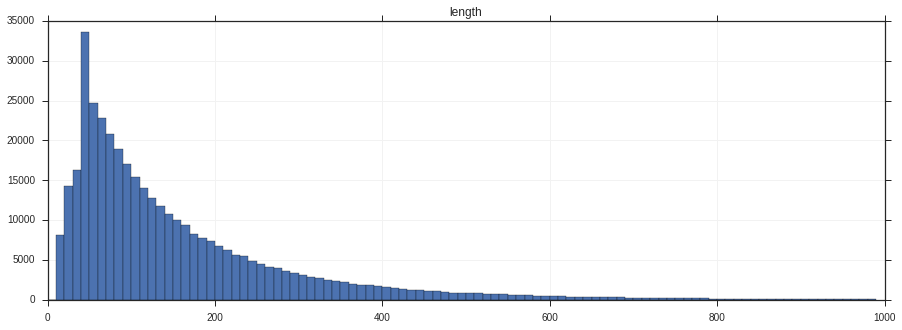

In [40]:
fig, ax = subplots(figsize=(15,5))
ax.hist(props["length"], bins=range(0, 1000, 10))
ax.set_title("length")
fig.show()

/home/sturm/bin/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


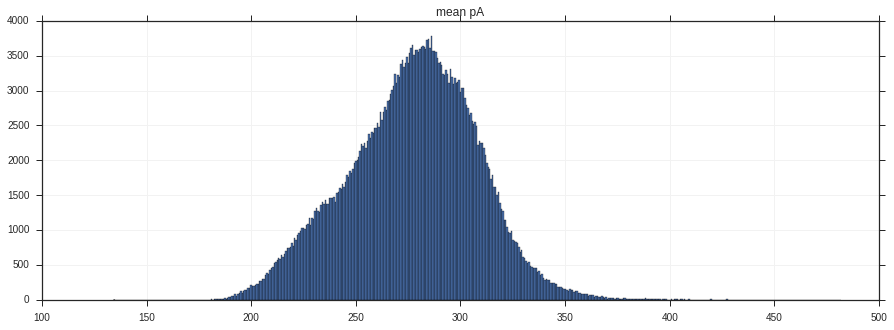

In [41]:
fig, ax = subplots(figsize=(15,5))
ax.hist(props["mean"], bins=500)
ax.set_title("mean pA")
fig.show()

/home/sturm/bin/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


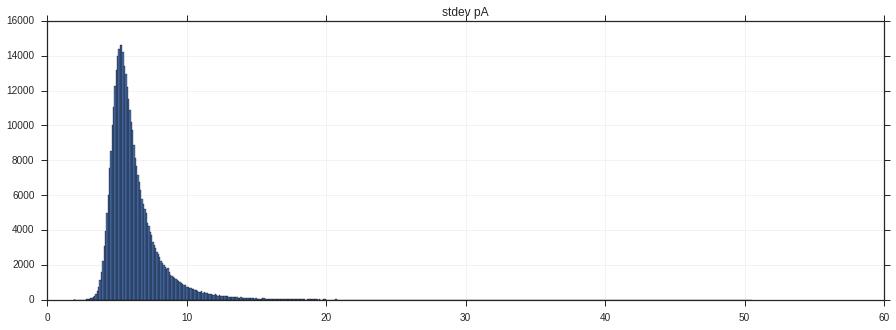

In [42]:
fig, ax = subplots(figsize=(15,5))
ax.hist(props["stdev"], bins=500)
ax.set_title("stdev pA")
fig.show()

#find all correctly mapped N-mers

In [43]:
NMER = 3
kmer_aligner = KmerAligner(ref, verbose=True, nmer=NMER)

Query Length 16299


In [44]:
true_events = []

for file in file_data:
    tmp_events = kmer_aligner.align_file(file)
    true_events.extend(tmp_events)
    
kmer_aligner.print_statistics()

processing ch 149 file 3

        Start/End Query 5270/12963 Target 0/7446 Skipped 4
        Length 7446/7450 Identity 0.25933
        
processing ch 133 file 11

        Start/End Query 0/6578 Target 938/6866 Skipped 939
        Length 5928/6867 Identity 0.28104
        
processing ch 204 file 8

        Start/End Query 6545/15137 Target 1/7603 Skipped 3
        Length 7602/7605 Identity 0.32386
        
processing ch 215 file 27

        Start/End Query 0/6580 Target 692/6600 Skipped 694
        Length 5908/6602 Identity 0.27065
        
processing ch 215 file 4

        Start/End Query 3910/5945 Target 0/1969 Skipped 3
        Length 1969/1972 Identity 0.27019
        
processing ch 215 file 14

        Start/End Query 4995/12084 Target 0/6876 Skipped 2
        Length 6876/6878 Identity 0.25844
        
processing ch 223 file 21

        Start/End Query 6551/13478 Target 4/6253 Skipped 7
        Length 6249/6256 Identity 0.31173
        
processing ch 203 file 2

        Start/End Q

In [45]:
len(true_events)

11810

well, that's not a lot!

### make dict with all kmers 

In [46]:
from itertools import product
all_5mers = [''.join(i) for i in product("ACGT",repeat=NMER)]
ev_map = OrderedDict((k,[]) for k in all_5mers)

In [47]:
for ev in true_events: 
    ev_map[ev["kmer"][:NMER]].append(ev)

#Analysis

### compare with distributions in sequence

* kmer-frequence
* length (how many kmers were mapped correctly, at all) 

In [48]:
from collections import OrderedDict
import scipy as sp

In [49]:
kmer_freq = OrderedDict((k, 0) for k in all_5mers)
for i in range(0, len(ref)-(NMER-1)):
    kmer_freq[ref[i:i+NMER]] += 1

In [50]:
true_kmer_freq = OrderedDict((k, len(v)) for k, v in ev_map.items())

In [51]:
sp.stats.pearsonr(list(true_kmer_freq.values()), list(kmer_freq.values()))

(0.92116844571302281, 4.2333338505075762e-27)

/home/sturm/bin/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


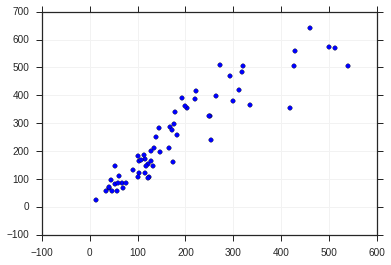

In [52]:
fig, ax = subplots()
ax.scatter(list(true_kmer_freq.values()), list(kmer_freq.values()))
fig.show()

#### outliers = kmers that are difficult to predict

In [53]:
# for kmer in kmer_freq.keys():
#     if (true_kmer_freq[kmer] == 0 and kmer_freq[kmer] < 30): continue
#     elif true_kmer_freq[kmer] == 0 or (kmer_freq[kmer]/true_kmer_freq[kmer] > 20):
#         print(kmer)

In [54]:
tr = sum(list(true_kmer_freq.values()))
tot = sum([len(f["called_seq"]) for f in file_data])
print("true_kmers ", tr)
print("total_kmers in reads", tot)
print("ratio", tr/tot)

true_kmers  11810
total_kmers in reads 407165
ratio 0.029005440055


### => Result

* the number of reads that are *totally* correct is really low...
    * (this is partly due to the fact, that the alignments are cropped)
* there is a pretty strong correlation (pearson r = .7) between the frequency of kmers in the reference and the frequency of correctly predicted kmers
    * this indicates that there is no direct evidence for specific base-pairs to be perdicted at low accuracy (there could be single ones, however)
   

## compare features

In [55]:
def sorted_boxplot(ordered_dict):
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
    map2 = OrderedDict(sorted(ordered_dict.items(), key=lambda x : 0 if len(x[1]) == 0 else np.mean(x[1])))
    fig, ax = subplots(figsize = (15, 5))
    boxplot(list(map2.values()))
    ax.set_xticklabels(list(map2.keys()), rotation=90, fontsize=8)
    fig.show()

### mean pA

In [56]:
pa_map = {}
for kmer, events in ev_map.items():
    kmer_means = []
    for ev in events: 
        l, r = ev["start"], ev["end"]
        ch = ev["channel"]
        kmer_means.append(np.mean(all_raw[ch][l:r]))
    pa_map[kmer] = kmer_means

/home/sturm/bin/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


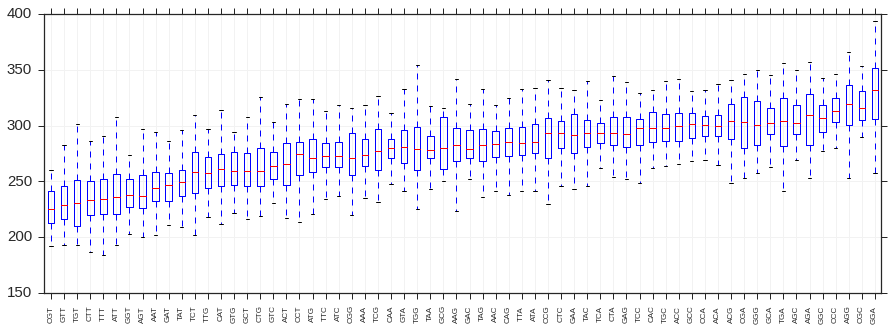

In [57]:
sorted_boxplot(pa_map)

### mean stdev

/home/sturm/bin/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


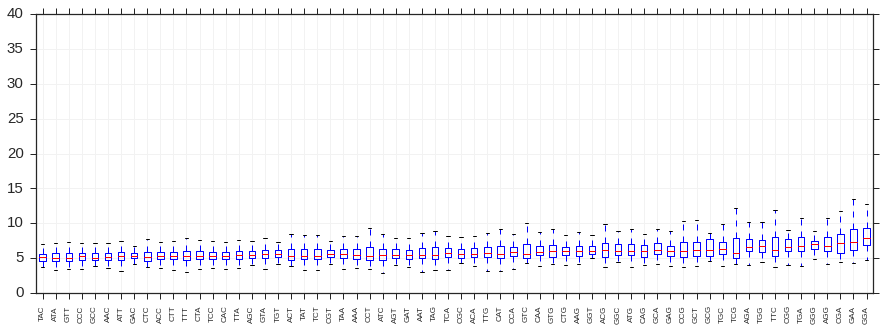

In [58]:
stdev_map = {}
for kmer, events in ev_map.items():
    kmer_std = []
    for ev in events: 
        l, r = ev["start"], ev["end"]
        ch = ev["channel"]
        kmer_std.append(np.std(all_raw[ch][l:r]))
    stdev_map[kmer] = kmer_std
sorted_boxplot(stdev_map)

### mean length

/home/sturm/bin/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


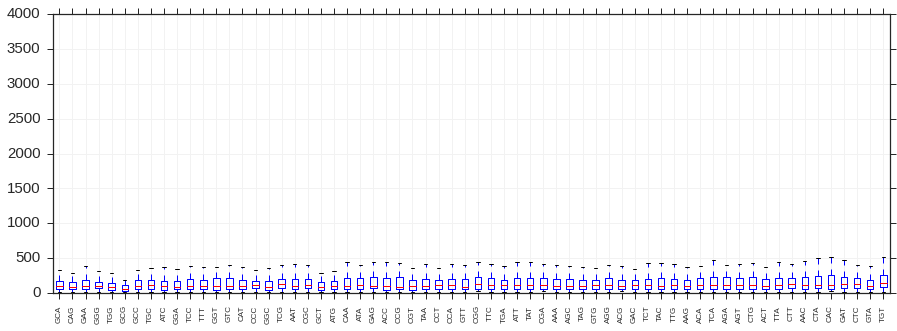

In [59]:
len_map = {}
for kmer, events in ev_map.items():
    kmer_len = []
    for ev in events: 
        l, r = ev["start"], ev["end"]
        kmer_len.append(r-l)
    len_map[kmer] = kmer_len
sorted_boxplot(len_map)